In [65]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import randint, uniform

### Load metadata

In [52]:
metadata = pd.read_csv("../metadata.csv", sep=";")

### Load features and labels

In [53]:
X = pd.read_csv("./features.csv", sep=";")
y = pd.read_csv("../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)

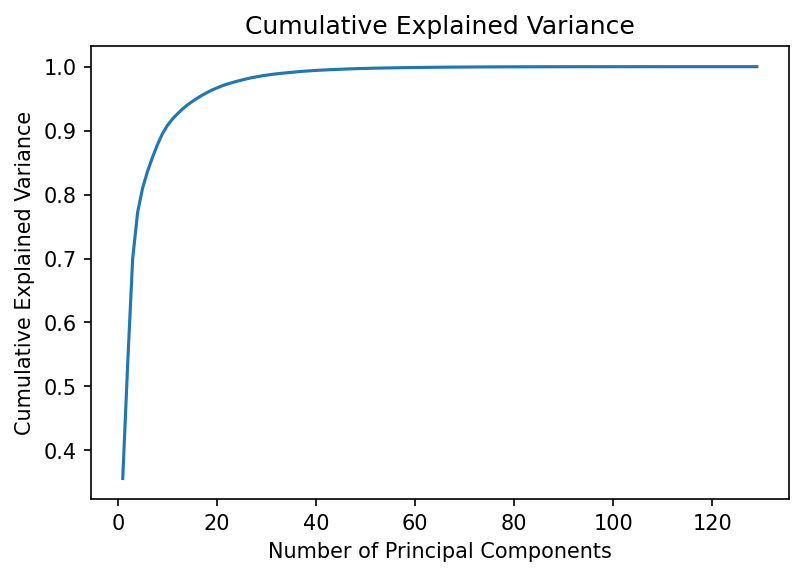

In [54]:
# Perform PCA
pca = PCA()
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Split the data into train and test

In [55]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Grid Search for PCA and Random Forest Classifier

In [56]:
# Define the Pipeline
pipeline = Pipeline([
    ('variance_filter', VarianceThreshold()), # Step 0: filter out variables with variance < threshold
    ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('min_max_scaler', MinMaxScaler()),  # Step 2: min-max scaling
    ('pca', PCA()),  # Step 3: PCA
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])

In [ ]:
#Define the parameter grid for grid search
param_grid = {
    'variance_filter__threshold': [0.0, 0.1, 0.2, 0.3, 0.4], # grid search value for variance filter threshold
    'pca__n_components': [1, 5, 10, 15, 20, 25, 30],  # Step 3:grid search number of components
    'rf__n_estimators': [100, 150, 200, 250, 300, 350],  # Step 4: grid search for n_estimators
    'rf__max_depth': [25, 50, 100, 200, 250, 300, None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}
# param_grid = {
#     'variance_filter__threshold': [0.1], # grid search value for variance filter threshold
#     'pca__n_components': [20, 25],  # Step 3:grid search number of components
#     'rf__n_estimators': [250],  # Step 4: grid search for n_estimators
#     'rf__max_depth': [None],  # Step 4: grid search for max_depth
#     'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
#     'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
# }

# Define the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions on the testing data
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
grid_search.best_params_

In [64]:
# Define the parameter distributions to sample from
param_distributions = {
    'variance_filter__threshold': uniform(0, 0.5),
    'pca__n_components': randint(1, 40),
    'rf__n_estimators': randint(100, 1000),
    'rf__max_depth': randint(10, 300),
    'rf__criterion' :['gini', 'entropy', 'log_loss'],
    'rf__max_features': ['sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42)

# Fit the pipeline to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Best Parameters:  {'rf__max_depth': 44, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 9, 'rf__min_samples_split': 4, 'rf__n_estimators': 252}
Best Score:  0.6695238095238096
